# loading data

loads data in a dictionary with 4 labels and normalise it

In [1]:
import os
import scipy.io
import numpy as np

raw_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}

training_dir = os.path.join('..', 'data', 'training')
validation_dir = os.path.join('..', 'data', 'validation')

for Dir in [training_dir, validation_dir]:
    for Class in ['normal', 'af', 'other', 'noisy']:
        class_dir = os.path.join(Dir, Class)
        for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
            mat_data = scipy.io.loadmat(file)
            sequence = mat_data['val'][0]
            normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
            raw_data[Class].append(normalised_sequence)

## pre-processing

transform data into 10s segments, remainders are 0 padded. Then downsample to 150Hz (or dont).
Padding using "reflect" adds ~5% accuracy over "mean"

In [7]:
print('normal:', len(raw_data['normal']))
print('af:', len(raw_data['af']))
print('other:', len(raw_data['other']))
print('noisy:', len(raw_data['noisy']), '\n')
print('total:', len(raw_data['normal']) + len(raw_data['af']) + len(raw_data['other']) + len(raw_data['noisy']))
print('----')

l = []
for Class in raw_data.keys():
    for i in raw_data[Class]:
        l.append(len(i))

print(np.max(l)/300)

normal: 5200
af: 788
other: 2526
noisy: 314 

total: 8828
----
60.95333333333333


In [2]:
data = {'normal': [], 'af': [], 'other': [], 'noisy': []}
sampling_freq = 300
down_freq = 300

R = sampling_freq // down_freq
for key in raw_data.keys():
    for d in raw_data[key]:
        for i in range(0, len(d)+10*(sampling_freq), 10*(sampling_freq)):
            if i+(10*(sampling_freq)) <= len(d):
                data[key].append(d[i:i+10*(sampling_freq)])                
            elif i < len(d):
                arr = d[i:]
                arr = np.pad(arr, (0, 10*sampling_freq-len(arr)), 'reflect')
                data[key].append(arr)
            data[key][-1] = data[key][-1].reshape(-1, R).mean(axis=1)

In [3]:
print('normal:', len(data['normal']))
print('af:', len(data['af']))
print('other:', len(data['other']))
print('noisy:', len(data['noisy']), '\n')
print('total:', len(data['normal']) + len(data['af']) + len(data['other']) + len(data['noisy']))

print(len(data['af'][0]))

normal: 17250
af: 2621
other: 8942
noisy: 859 

total: 29672
3000


# SQIs

ECG Signal Quality During Arrhythmia and Its
Application to False Alarm Reduction
Joachim Behar∗, Julien Oster, Qiao Li, and Gari D. Clifford, Senior Member, IEEE

## Skewness and Kurtosis

In [4]:
from scipy.stats import skew, kurtosis

skewness = {'normal': [], 'af': [], 'other': [], 'noisy': []}
kurt = {'normal': [], 'af': [], 'other': [], 'noisy': []}

for Class in skewness.keys():
    for i in data[Class]:
        skewness[Class].append(skew(i, bias=False))
        kurt[Class].append(kurtosis(i, fisher=False, bias=False))

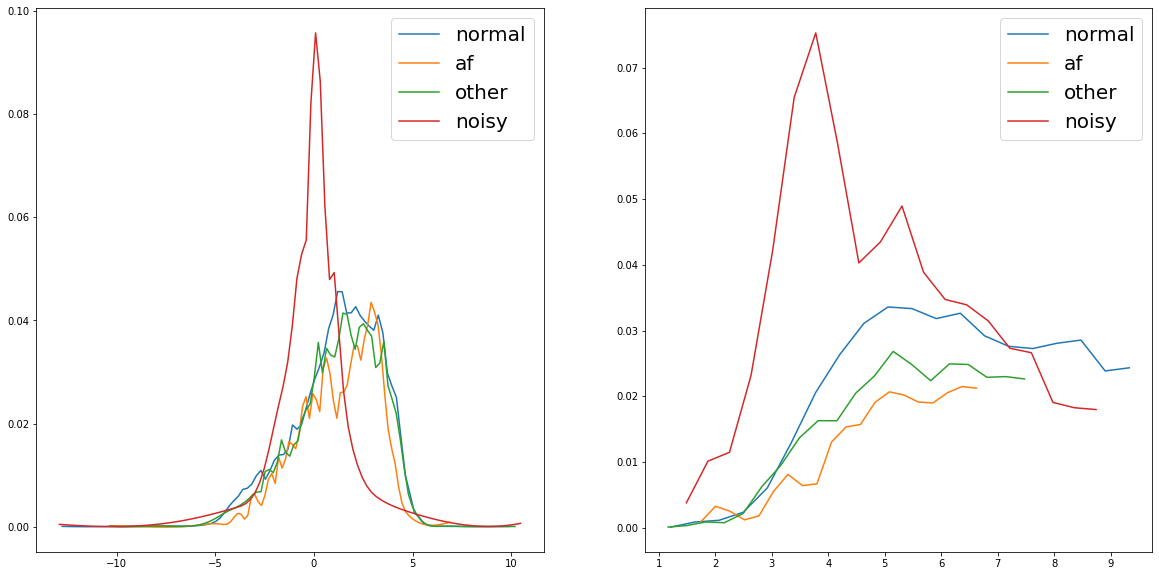

In [5]:
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

for Class in skewness.keys():
    p, x = np.histogram(skewness[Class], bins=100)
    x = x[:-1] + (x[1] - x[0])/2
    f = UnivariateSpline(x, p, s=500)
    pdf = f(x) / len(skewness[Class])
    axs[0].plot(x, pdf, label=Class)
    
for Class in kurt.keys():
    n_bins = 500
    s = 500
    p, x = np.histogram(kurt[Class], bins=n_bins)
    x = x[:-1] + (x[1] - x[0])/2
    f = UnivariateSpline(x, p, s=s)
    pdf = f(x) / len(skewness[Class])
    axs[1].plot(x[:20], pdf[:20], label=Class)

axs[0].legend(loc=1, prop={'size': 20})
axs[1].legend(loc=1, prop={'size': 20})

## pSQI and basSQI 

(bassqi is much better with 300Hz)

In [6]:
from scipy.signal import welch
from scipy.integrate import simps

def get_first_idx(x, a):
    for i in range(len(x)):
        if x[i] >= a:
            return i

def get_last_idx(x, a):
    for i in range(len(x)):
        if x[i] >= a:
            return i-1
        
psqi = {'normal': [], 'af': [], 'other': [], 'noisy': []}
bassqi = {'normal': [], 'af': [], 'other': [], 'noisy': []}

for Class in skewness.keys():
    for i in data[Class]:
        f, Pxx_den = welch(i, fs=150)
        u1 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 15)], x=f[get_first_idx(f, 5):get_last_idx(f, 15)])
        u2 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 40)], x=f[get_first_idx(f, 5):get_last_idx(f, 40)])
        u3 = simps(Pxx_den[get_first_idx(f, 1):get_last_idx(f, 40)], x=f[get_first_idx(f, 1):get_last_idx(f, 40)])
        u4 = simps(Pxx_den[get_first_idx(f, 0):get_last_idx(f, 40)], x=f[get_first_idx(f, 0):get_last_idx(f, 40)])
        
        psqi[Class].append(u1/u2)
        bassqi[Class].append(u3/u4)

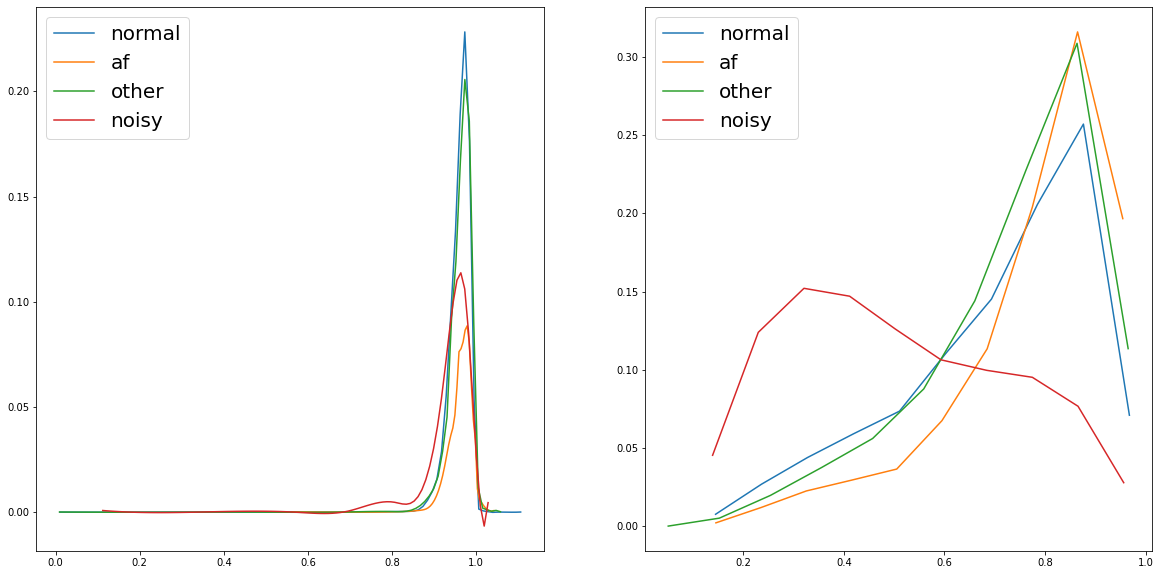

In [7]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 10)


for Class in psqi.keys():
    psqi[Class] = np.array(psqi[Class])[~np.isnan(psqi[Class])]

    p, x = np.histogram(psqi[Class], bins=100)
    x = x[:-1] + (x[1] - x[0])/2
    f = UnivariateSpline(x, p, s=1000)
    pdf = f(x) / len(psqi[Class])
    axs[0].plot(x, pdf, label=Class)
    
for Class in bassqi.keys():
    n_bins = 10
    s = 500
    
    bassqi[Class] = np.array(bassqi[Class])[~np.isnan(bassqi[Class])]
    
    p, x = np.histogram(bassqi[Class], bins=n_bins)
    x = x[:-1] + (x[1] - x[0])/2
    f = UnivariateSpline(x, p, s=s)
    pdf = f(x) / len(bassqi[Class])
    axs[1].plot(x, pdf, label=Class)

axs[0].legend(loc=2, prop={'size': 20})
axs[1].legend(loc=2, prop={'size': 20})

## WQRS

contributed to: https://github.com/berndporr/py-ecg-detectors/commit/387036a6cea3296d1e7a02486d2568137244b110
### Low pass filter

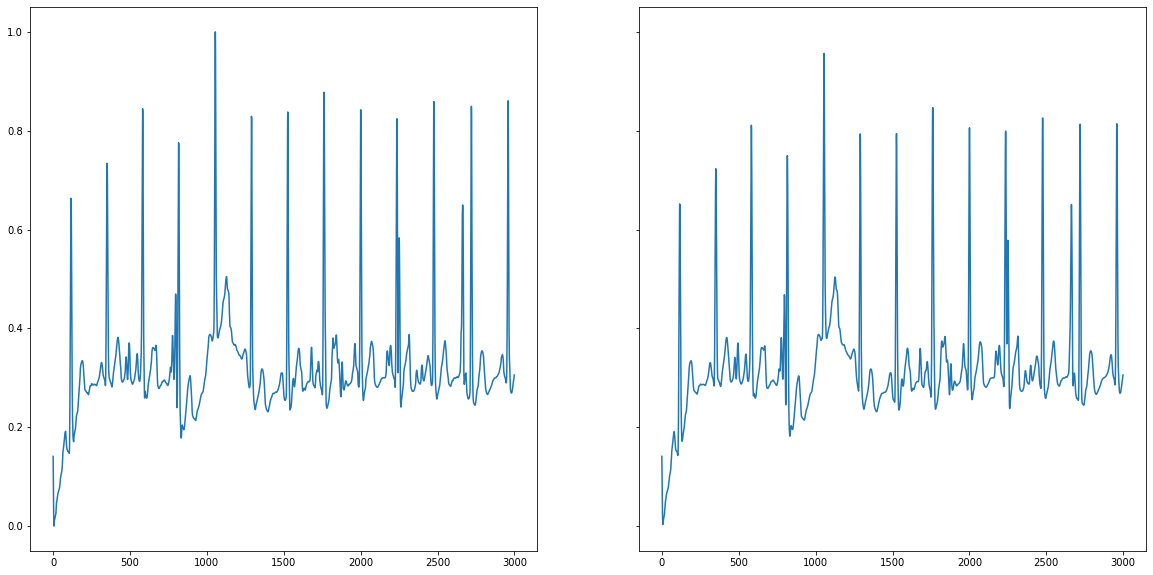

In [8]:
from scipy.signal import butter,filtfilt

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(20, 10)

def butter_lowpass_filter(data, cutoff):
    T = 10         # Sample Period
    fs = 150      # sample rate, Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2
    n = int(T * fs) # total number of samples

    normal_cutoff = cutoff / nyq
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y = butter_lowpass_filter(data['normal'][0], 15)
axs[0].plot(data['normal'][0])
axs[1].plot(y)


### length transform and thresholding

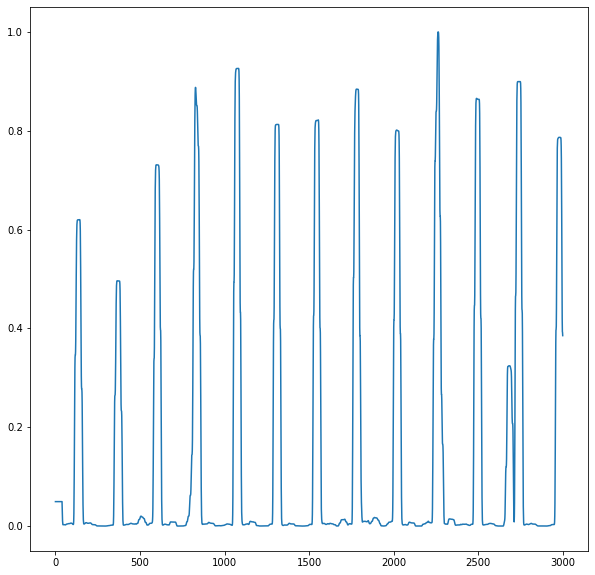

In [9]:
import math
def length_transfrom(x, w):
    fs = 300
    tmp = []
    for i in range(w, len(x)):
        curr = 0
        for k in range(i-w+1, i):
            curr += np.sqrt((20/fs)+np.power(x[k]-x[k-1],2))
        tmp.append(curr)
    l = [tmp[0]]*w
    
    return l+tmp

def threshold(x):
    u = np.mean(x)
    peaks = []
    fs = 300
    for i in range(len(x)):
        if (len(peaks) == 0 or i > peaks[-1]+(fs*0.18)) and x[i] > u:
            peaks.append(i)
    return peaks

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10, 10)

fs = 300
y = butter_lowpass_filter(data['normal'][0], 15)
y = length_transfrom(y, math.ceil(fs*0.130))
y = (y- min(y)) / (max(y) - min(y))
axs.plot(y)


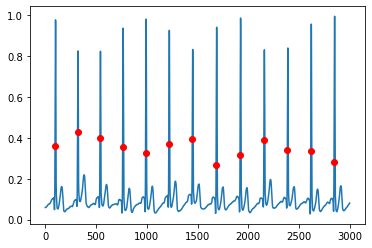

In [10]:
def wqrs(x):
    fs = 130
    y = butter_lowpass_filter(x, 15)
    y = length_transfrom(y, math.ceil(fs*.130))
    return threshold(y)

x = data['normal'][10]
peaks = wqrs(x)
plt.plot(x)
plt.plot(peaks, np.array(x)[peaks],'ro')

## bSQI and rSQI

In [11]:
from tqdm import tqdm
from ecgdetectors import Detectors
detectors = Detectors(fs)

bsqi = {'normal': [], 'af': [], 'other': [], 'noisy': []}
rsqi = {'normal': [], 'af': [], 'other': [], 'noisy': []}

fs = 300

for Class in skewness.keys():
    for i in tqdm(data[Class][:800]):
        _wqrs = wqrs(i)
        eplimited = detectors.hamilton_detector(i)
        count = 0
        j = 0
        k = 0
        while j < len(_wqrs) and k < len(eplimited):
            if _wqrs[j] >= eplimited[k]-0.13*fs and _wqrs[j] <= eplimited[k]+0.13*fs:
                count += 1
                j+=1
                k+=1
            elif _wqrs[j] > eplimited[k]:
                k+=1
            else:
                j+=1
        bsqi[Class].append(count/len(_wqrs))
        rsqi[Class].append(len(_wqrs)/(len(_wqrs)+len(eplimited)))
        

100%|███████████████████████████████████████████████████████| 800/800 [03:45<00:00,  3.55it/s]


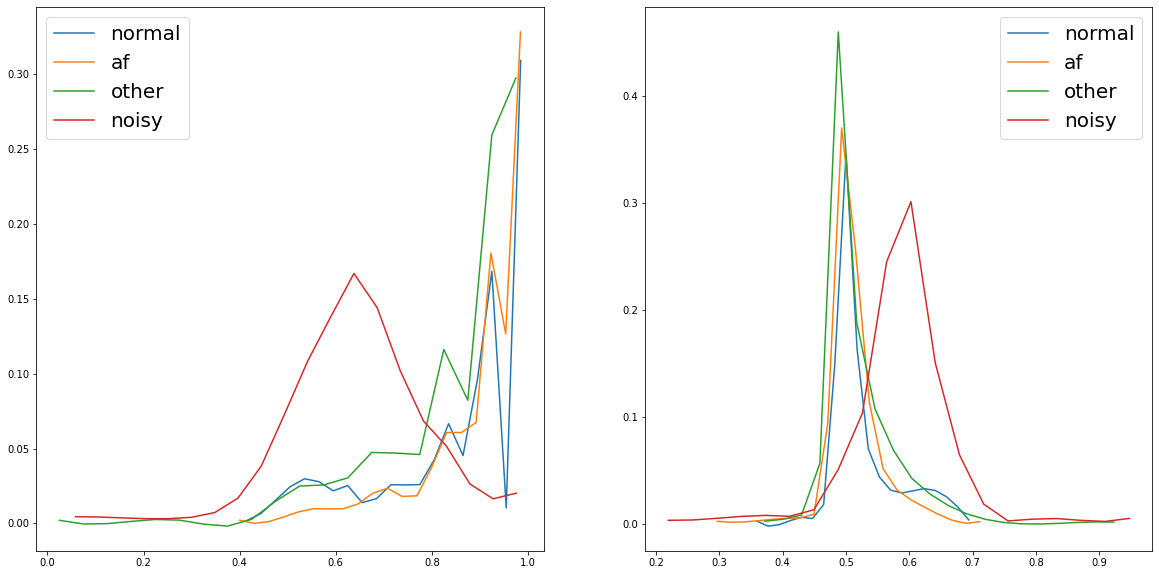

In [12]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 10)


for Class in bsqi.keys():
    p, x = np.histogram(bsqi[Class], bins=20)
    x = x[:-1] + (x[1] - x[0])/2
    f = UnivariateSpline(x, p, s=100)
    pdf = f(x) / len(bsqi[Class])
    axs[0].plot(x, pdf, label=Class)
    
for Class in rsqi.keys():
    n_bins = 20
    s = 200
        
    p, x = np.histogram(rsqi[Class], bins=n_bins)
    x = x[:-1] + (x[1] - x[0])/2
    f = UnivariateSpline(x, p, s=s)
    pdf = f(x) / len(rsqi[Class])
    axs[1].plot(x, pdf, label=Class)

axs[0].legend(loc=2, prop={'size': 20})
axs[1].legend(loc=1, prop={'size': 20})

In [13]:
tmp = np.array(rsqi['normal'])
len(tmp[tmp >= 0.5])/len(tmp)

0.8225

In [14]:
print('normal:', len(raw_data['normal']))
print('af:', len(data['af']))
print('other:', len(data['other']))
print('noisy:', len(data['noisy']), '\n')
print('total:', len(data['normal']) + len(data['af']) + len(data['other']) + len(data['noisy']))

normal: 5200
af: 2621
other: 8942
noisy: 859 

total: 29672


# SVM 

(88% for 800 records per class)
much much better when normalising psqi and ksqi
feels like 0 padding almost always get classified as noisy

(92-95% for 800 records per class)
using reflective padding instead of mean

In [15]:
import pandas as pd

ssqi = {'normal': [], 'af': [], 'other': [], 'noisy': []}
ksqi = {'normal': [], 'af': [], 'other': [], 'noisy': []}

for Class in skewness.keys():
    ssqi[Class] = (skewness[Class])
    ksqi[Class] = (kurt[Class])

train = pd.DataFrame()
train['sSQI'] = np.concatenate([ssqi['normal'][:320], ssqi['af'][:160], ssqi['other'][:160], ssqi['noisy'][:640]])
train['kSQI'] = np.concatenate([ksqi['normal'][:320], ksqi['af'][:160], ksqi['other'][:160], ksqi['noisy'][:640]])
train['pSQI'] = np.concatenate([psqi['normal'][:320], psqi['af'][:160], psqi['other'][:160], psqi['noisy'][:640]])
train['basSQI'] = np.concatenate([bassqi['normal'][:320], bassqi['af'][:160], bassqi['other'][:160], bassqi['noisy'][:640]])
train['bSQI'] = np.concatenate([bsqi['normal'][:320], bsqi['af'][:160], bsqi['other'][:160], bsqi['noisy'][:640]])
train['rSQI'] = np.concatenate([rsqi['normal'][:320], rsqi['af'][:160], rsqi['other'][:160], rsqi['noisy'][:640]])
train['target'] = np.concatenate([[0]*640, [1]*640])

test = pd.DataFrame()
test['sSQI'] = np.concatenate([ssqi['normal'][320:400], ssqi['af'][160:200], ssqi['other'][160:200], ssqi['noisy'][640:800]])
test['kSQI'] = np.concatenate([ksqi['normal'][320:400], ksqi['af'][160:200], ksqi['other'][160:200], ksqi['noisy'][640:800]])
test['pSQI'] = np.concatenate([psqi['normal'][320:400], psqi['af'][160:200], psqi['other'][160:200], psqi['noisy'][640:800]])
test['basSQI'] = np.concatenate([bassqi['normal'][320:400], bassqi['af'][160:200], bassqi['other'][160:200], bassqi['noisy'][640:800]])
test['bSQI'] = np.concatenate([bsqi['normal'][320:400], bsqi['af'][160:200], bsqi['other'][160:200], bsqi['noisy'][640:800]])
test['rSQI'] = np.concatenate([rsqi['normal'][320:400], rsqi['af'][160:200], rsqi['other'][160:200], rsqi['noisy'][640:800]])
test['target'] = np.concatenate([[0]*160, [1]*160])

sSQI_u = train['sSQI'].mean() 
kSQI_u = train['kSQI'].mean() 

sSQI_var = train['sSQI'].var() 
kSQI_var = train['kSQI'].var() 

train['sSQI'] = train['sSQI'].apply(lambda x: (x-sSQI_u) / np.sqrt(sSQI_var))
train['kSQI'] = train['kSQI'].apply(lambda x: (x-kSQI_u) / np.sqrt(kSQI_var))

test['sSQI'] = test['sSQI'].apply(lambda x: (x-sSQI_u) / np.sqrt(sSQI_var))
test['kSQI'] = test['kSQI'].apply(lambda x: (x-kSQI_u) / np.sqrt(kSQI_var))

print(train.head())

       sSQI      kSQI      pSQI    basSQI      bSQI      rSQI  target
0  0.774529  0.026056  0.982391  0.850981  0.928571  0.500000       0
1  1.608524  0.664384  0.981687  0.901647  1.000000  0.480000       0
2  1.513138  0.512333  0.978652  0.895839  0.928571  0.518519       0
3  0.001607 -0.084748  0.981497  0.435906  0.875000  0.533333       0
4  1.488933  0.564491  0.977397  0.921190  1.000000  0.500000       0


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load
import pandas as pd

df = pd.read_pickle("data_processed.pkl")
x_train = train.drop(['target'], axis='columns')
y_train = train.target

x_test = test.drop(['target'], axis='columns')
y_test = test.target

model = SVC(C=25, gamma=1, probability=True)
model.fit(x_train, y_train)

dump(model, 'model.joblib');

0.859375


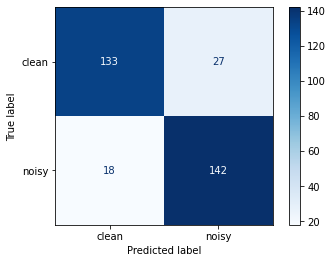

In [20]:
import matplotlib.pyplot as plt
model = load('model.joblib')

print(model.score(x_test, y_test))
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['clean', 'noisy'])
disp.plot(cmap=plt.cm.Blues)

In [21]:
errors = y_test[model.predict(x_test) != y_test]

[0.88692219 0.11307781]
True Class:  clean
Predicted Class:  clean


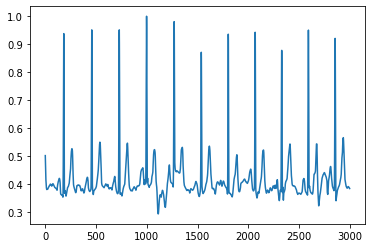

In [19]:
# samp = errors.sample()
samp = df.sample()

plot_idx = samp.index[0]

if plot_idx < 400:
    plot = data['normal'][plot_idx]
    true_class = 'clean'
elif plot_idx < 600:
    plot = data['af'][plot_idx-400]
    true_class = 'clean'
elif plot_idx < 800:
    plot = data['other'][plot_idx-600]
    true_class = 'clean'
else:
    plot = data['noisy'][plot_idx-800]
    true_class = 'noisy'

features = df.loc[[plot_idx]].drop('target', axis='columns')

probs = model.predict_proba(features)[0]
print(probs)
plt.plot(plot);
print('True Class: ', true_class)
print('Predicted Class: ', 'clean' if probs[0] >= probs[1] else 'noisy')

In [ ]:
# create a mesh to plot in
h = 0.02
x_min, x_max = x_test['sSQI'].min() - 1, x_test['sSQI'].max() + 1
y_min, y_max = x_test['bSQI'].min() - 1, x_test['bSQI'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

model = SVC(C=25, gamma=1, probability=True)
model.fit(x_train[['sSQI', 'bSQI']], y_train)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(x_test['sSQI'], x_test['bSQI'], c=y_test, cmap=plt.cm.coolwarm)
plt.xlabel('sSQI')
plt.ylabel('bSQI')
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.savefig('svm_1')

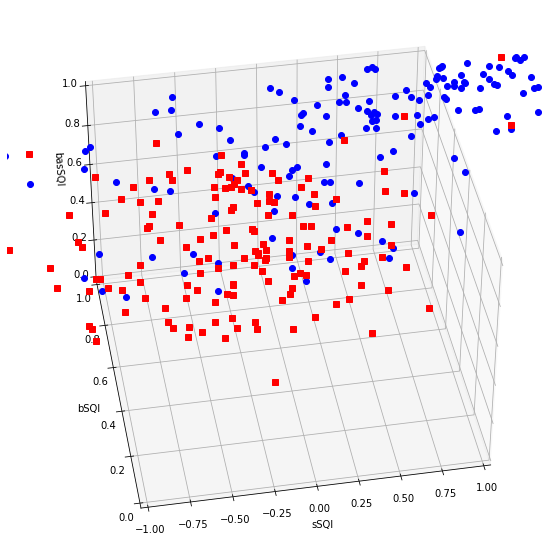

In [93]:
# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
# z = lambda x,y: (-model.intercept_[0]-model.coef_[0][0]*x_test -model.coef_[0][1]*y_test) / clf.coef_[0][2]

tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)

fig = plt.figure()
fig.set_size_inches(20, 10)
ax  = fig.add_subplot(111, projection='3d')
ax.plot3D(x_test[y_test==0]['sSQI'], x_test[y_test==0]['bSQI'], x_test[y_test==0]['basSQI'],'ob')
ax.plot3D(x_test[y_test==1]['sSQI'], x_test[y_test==1]['bSQI'], x_test[y_test==1]['basSQI'],'sr')
# ax.plot_surface(x, y, z(x,y))
ax.view_init(40, 260)
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 1)
ax.set_xlabel('sSQI')
ax.set_ylabel('bSQI')
ax.set_zlabel('basSQI')
plt.savefig('svm_2')
plt.show()


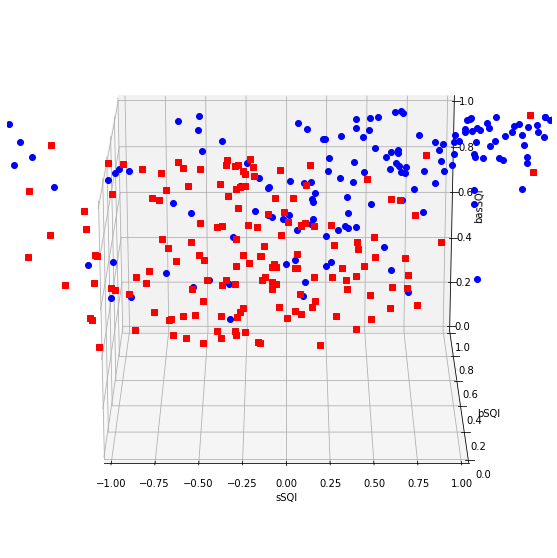

In [90]:
# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
# z = lambda x,y: (-model.intercept_[0]-model.coef_[0][0]*x_test -model.coef_[0][1]*y_test) / clf.coef_[0][2]
tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)

fig = plt.figure()
fig.set_size_inches(20, 10)

ax  = fig.add_subplot(111, projection='3d')
ax.plot3D(x_test[y_test==0]['sSQI'], x_test[y_test==0]['bSQI'], x_test[y_test==0]['basSQI'],'ob')
ax.plot3D(x_test[y_test==1]['sSQI'], x_test[y_test==1]['bSQI'], x_test[y_test==1]['basSQI'],'sr')
# ax.plot_surface(x, y, z(x,y))
ax.view_init(20, 270)
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 1)
ax.set_xlabel('sSQI')
ax.set_ylabel('bSQI')
ax.set_zlabel('basSQI')

plt.show()